In [8]:
from architectures import yolov8
from trackers import botsort
from data import yolo_dataset, image_processor
import wandb
import json
import os

> run `wandb login` in terminal before running this notebook

### Select a model, dataset, tracker and hyperparameters

In [9]:
architectures = {
  "yolov8": yolov8.YoloV8
}

trackers = {
  'botsort': botsort.BotSort
  }

dataset_mapping = {
 "yolov8": yolo_dataset.YoloDataset
  }

In [10]:
STD_MODEL_FOLDER = '/vol/biomedic3/bglocker/ugproj2324/fv220/dev/SharkTrack-Dev/model_development/models'
REQUIRED_TRAIN_PARAMS = ["model_name", "model_path", "architecture", "epochs", "batch_size", "img_size", "lr", "greyscale", "model_size", "patience", "training_data", "pretrained_model_path", "annotations_path"]
REQUIRED_EVAL_PARAMS = ["conf_threshold", "eval_data", "iou_association_threshold", "tracker"]
DYNAMIC_PARAMS = ["pretrained", "fine_tuning"]

def load_trained_models():
    with open("./assets/trained_models.json", "r") as file:
        return json.load(file)

def check_required_params(params, required_params):
    return all(param in params for param in required_params)

def create_model_path(model_name):
    model_path = f"{STD_MODEL_FOLDER}/{model_name}"
    assert not os.path.exists(model_path), f"Model {model_name} already exists."
    return model_path

def get_pretrained_model_path(model_name, trained_models):
    assert model_name in trained_models, "Pretrained model is not available."
    model_path = trained_models[model_name]["model_path"]
    assert os.path.exists(model_path), f"Pretrained model {model_name} does not exist."
    return model_path

def construct_hyperparameters(**config):
    trained_models = load_trained_models()
    assert trained_models is not None, "Trained models data is not available."

    hyperparameters = {"model_name": config["model_name"]}
    model_pretrained = hyperparameters["model_name"] in trained_models
    fine_tuning = not model_pretrained and config["pretrained_model_path"] is not None

    if model_pretrained:
        assert config["pretrained_model_path"] is None, "Pretrained model path is not required."
        model_train_params = trained_models[hyperparameters["model_name"]]
        assert model_train_params is not None and check_required_params(model_train_params, REQUIRED_TRAIN_PARAMS), "Missing required training parameters."
        hyperparameters.update({param: model_train_params[param] for param in REQUIRED_TRAIN_PARAMS})
        hyperparameters.update({param: config[param] for param in REQUIRED_EVAL_PARAMS})
    else:
        model_path = create_model_path(hyperparameters["model_name"])
        hyperparameters.update({**config, "model_path": model_path})
        if fine_tuning:
            assert "pretrained_model_path" in config, "Pretrained model path is missing."
            if '/' not in config["pretrained_model_path"]:
                # passed model name, not path
                model_path = get_pretrained_model_path(config["pretrained_model_path"], trained_models)
                hyperparameters["pretrained_model_path"] = model_path
        hyperparameters['annotations_path'] = os.path.join(hyperparameters["model_path"], "annotations.csv")

    hyperparameters['pretrained'] = model_pretrained
    hyperparameters['fine_tuning'] = fine_tuning

    assert check_required_params(hyperparameters, REQUIRED_TRAIN_PARAMS + REQUIRED_EVAL_PARAMS + DYNAMIC_PARAMS), "Some required hyperparameters are missing."

    return hyperparameters

def save_hyperparameters(hyperparameters):
    with open("./assets/trained_models.json", "r+") as file:
        trained_models = json.load(file)
        trained_models[hyperparameters['model_name']] = hyperparameters
        file.seek(0)
        json.dump(trained_models, file, indent=4)
        file.truncate()


In [11]:
def prepare_dataset(hyperparameters, metrics):
    transforms = [image_processor.ImageProcessor.bgr2rgb]
    data_dir = "/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/images_raw/"
    data_config = hyperparameters['training_data']
    dataset_class = dataset_mapping[hyperparameters['architecture']]
    dataset = dataset_class(data_config['dataset_name'], data_dir, data_config['datasets'], data_config.get('augmentations', []), transforms)
    dataset.get_info()
    metrics['dataset_size'] = len(dataset)
    return dataset, metrics

def train_model(model, dataset, metrics):
    print("Training model...")
    train_time, dataset_time, device, final_model_path, mAP = model.train(dataset)
    metrics['training_time'] = train_time
    metrics['dataset_building_time'] = dataset_time
    metrics['training_device'] = device
    metrics['mAP'] = mAP
    return final_model_path, metrics

def evaluate_model(model, metrics):
    mota, motp, idf1, track_time, device = model.evaluate()
    metrics['mota'] = mota
    metrics['motp'] = motp
    metrics['idf1'] = idf1
    metrics['tracking_time'] = track_time
    metrics['tracking_device'] = device
    # TODO: log image as well
    return metrics

def log_images(model_path):
    model_folder = os.path.dirname(model_path)
    plot_names = [f for f in os.listdir(model_folder) if os.path.isfile(os.path.join(model_folder, f)) and f.endswith('.png')]
    for plot in plot_names:
        wandb.log({plot: wandb.Image(os.path.join(model_folder, plot))})

def model_experimentation(hyperparameters):
    try:
        tracker = trackers[hyperparameters['tracker']]()
        model = architectures[hyperparameters['architecture']](hyperparameters, tracker)
        metrics = {}
        
        # Training
        if not hyperparameters['pretrained']:
            dataset, metrics = prepare_dataset(hyperparameters, metrics)
            metrics['dataset_size'] = len(dataset)
            final_model_path, metrics = train_model(model, dataset, metrics)
            hyperparameters['model_path'] = final_model_path

        metrics = evaluate_model(model, metrics)
        save_hyperparameters(hyperparameters)
        
        print('Initialising wandb...')
        wandb.init(project="SharkTrack", name=hyperparameters["model_name"], config=hyperparameters, job_type="training")
        log_images(hyperparameters['model_path'])
        wandb.log(metrics)
        wandb.finish()
    finally:
        wandb.finish()



### Delete model

In [12]:
# Delete folder from model_development/models
# Delete entry from trained_models.json

def delete_model(model_name):
  model_path = f"{STD_MODEL_FOLDER}/{model_name}"
  assert os.path.exists(model_path), f"Model {model_name} does not exist."
  os.system(f"rm -rf {model_path}")
  with open("./assets/trained_models.json", "r+") as file:
    trained_models = json.load(file)
    if model_name in trained_models:
      del trained_models[model_name]
      file.seek(0)
      json.dump(trained_models, file, indent=4)
      file.truncate()

## Construct Hyperparameters

In [13]:
# delete_model("test_yolo")


model_name = "yolov8n-test"
dataset_params = {
  "dataset_name": "test_mvd",
  "datasets": {
        "rf1": 0.05,
        "rf2": 0.05,
        "rf3": 0.05,
        "mwitt": 0.05,
        "openimagesv7": 0.05,
        "sl": 0.05,
        "backgrounds": 0.05
  },
  # "augmentations": ["Equalise", "Rotate", "Crop", "Bbox-rotate", "Cutout"]
  "augmentations": []
}

train_params = {
  "model_name": "test_yolo_mAP_test1",
  "architecture": "yolov8",
  "epochs": 5,
  "batch_size": 16,
  "img_size": 640,
  "lr": 0.01,
  "greyscale": False,
  "model_size": "n",
  "pretrained_model_path": None, # we can specify the path of a pretrained model to use. MUST BE in ./assets/trained_models.json
  "patience": 10,
  "training_data": dataset_params
}

eval_params = {
  "conf_threshold": 0.2,
  "eval_data": "eval1",
  "iou_association_threshold": 0.5,
  "tracker": "botsort"
}

hyperparameters = construct_hyperparameters(**train_params, **eval_params)

print(hyperparameters)

{'model_name': 'test_yolo_mAP', 'architecture': 'yolov8', 'epochs': 5, 'batch_size': 16, 'img_size': 640, 'lr': 0.01, 'greyscale': False, 'model_size': 'n', 'pretrained_model_path': None, 'patience': 10, 'training_data': {'dataset_name': 'test_mvd', 'datasets': {'rf1': 0.05, 'rf2': 0.05, 'rf3': 0.05, 'mwitt': 0.05, 'openimagesv7': 0.05, 'sl': 0.05, 'backgrounds': 0.05}, 'augmentations': []}, 'conf_threshold': 0.2, 'eval_data': 'eval1', 'iou_association_threshold': 0.5, 'tracker': 'botsort', 'model_path': '/vol/biomedic3/bglocker/ugproj2324/fv220/dev/SharkTrack-Dev/model_development/models/test_yolo_mAP', 'annotations_path': '/vol/biomedic3/bglocker/ugproj2324/fv220/dev/SharkTrack-Dev/model_development/models/test_yolo_mAP/annotations.csv', 'pretrained': False, 'fine_tuning': False}


Training model from scratch


100%|██████████| 6.23M/6.23M [00:00<00:00, 113MB/s]


Initialised Model test_yolo_mAP 
Dataset size: {'rf1': 52, 'rf2': 219, 'rf3': 176, 'mwitt': 5, 'openimagesv7': 32, 'sl': 15, 'backgrounds': 13}


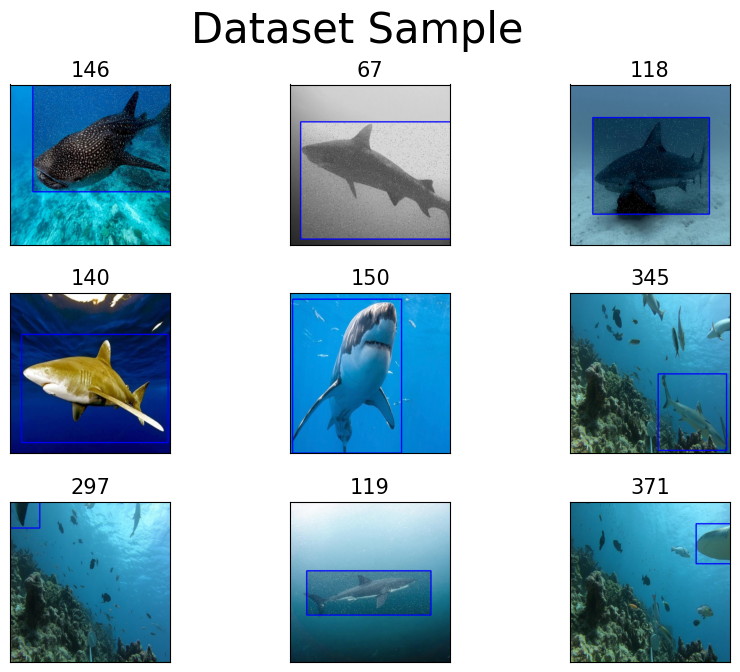

Training model...
Dataset already exists, skipping building step
Dataset built in 0.0 minutes
Saving model to /vol/biomedic3/bglocker/ugproj2324/fv220/dev/SharkTrack-Dev/model_development/models/test_yolo_mAP
Starting training...
Train params: {'data': '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/experimentation_datasets/test_mvd/data_config.yaml', 'epochs': 5, 'imgsz': 640, 'batch': 16, 'patience': 10, 'lr0': 0.01, 'lrf': 0.01, 'verbose': True, 'project': 'models', 'name': 'test_yolo_mAP'}
New https://pypi.org/project/ultralytics/8.1.8 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.0 🚀 Python-3.10.12 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/experimentation_datasets/test_mvd/data_config.yaml, epochs=5, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=mode

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /vol/biomedic3/bglocker/ugproj2324/fv220/datasets/experimentation_datasets/test_mvd/train/labels.cache... 409 images, 49 backgrounds, 0 corrupt: 100%|██████████| 409/409 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /vol/biomedic3/bglocker/ugproj2324/fv220/datasets/experimentation_datasets/test_mvd/val/labels.cache... 102 images, 16 backgrounds, 0 corrupt: 100%|██████████| 102/102 [00:00<?, ?it/s]


Plotting labels to models/test_yolo_mAP/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.11G      1.706      2.927      2.023         27        640: 100%|██████████| 26/26 [00:04<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]

                   all        102         97    0.00248      0.784     0.0556     0.0168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.21G      1.673      2.741       2.02         22        640: 100%|██████████| 26/26 [00:02<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.73it/s]

                   all        102         97      0.342      0.134      0.154     0.0587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.11G      1.735       2.77      2.127         25        640: 100%|██████████| 26/26 [00:02<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.73it/s]

                   all        102         97      0.279      0.135      0.119     0.0545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.11G      1.781      2.738      2.123         26        640: 100%|██████████| 26/26 [00:02<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.91it/s]

                   all        102         97      0.172      0.206      0.116     0.0412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5       2.1G        1.7      2.607      2.073         20        640: 100%|██████████| 26/26 [00:02<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]

                   all        102         97      0.301      0.216      0.157     0.0553



5 epochs completed in 0.006 hours.
Optimizer stripped from models/test_yolo_mAP/weights/last.pt, 6.2MB
Optimizer stripped from models/test_yolo_mAP/weights/best.pt, 6.2MB

Validating models/test_yolo_mAP/weights/best.pt...
Ultralytics YOLOv8.1.0 🚀 Python-3.10.12 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


                   all        102         97      0.346      0.134      0.155     0.0587
Speed: 0.2ms preprocess, 0.7ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to models/test_yolo_mAP


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


lr/pg0,▁▆█▆▆
lr/pg1,▁▆█▆▆
lr/pg2,▁▆█▆▆
metrics/mAP50(B),▁█▅▅█
metrics/mAP50-95(B),▁█▇▅█
metrics/precision(B),▁█▇▄█
metrics/recall(B),█▁▁▂▁
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▃▁▅█▃


Evaluating easy1


WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/598) /vol/biomedic3/bglocker/ugproj2324/fv220/datasets/sharktrack_test/videos/easy1.mp4: 384x640 (no detections), 120.8ms
video 1/1 (2/598) /vol/biomedic3/bglocker/ugproj2324/fv220/datasets/sharktrack_test/videos/easy1.mp4: 384x640 (no detections), 7.8ms
video 1/1 (3/598) /vol/biomedic3/bglocker/ugproj2324/fv220/datasets/sharktrack_test/videos/easy1.mp4: 384x640 (no detections), 7.8ms
video 1/1 (4/598) /vol/biomedic3/bgloc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


dataset_building_time,▁
dataset_size,▁
idf1,▁
mota,▁
motp,▁
tracking_time,▁
training_time,▁
dataset_building_time,0.0
dataset_size,512
idf1,0.0
mota,0.0


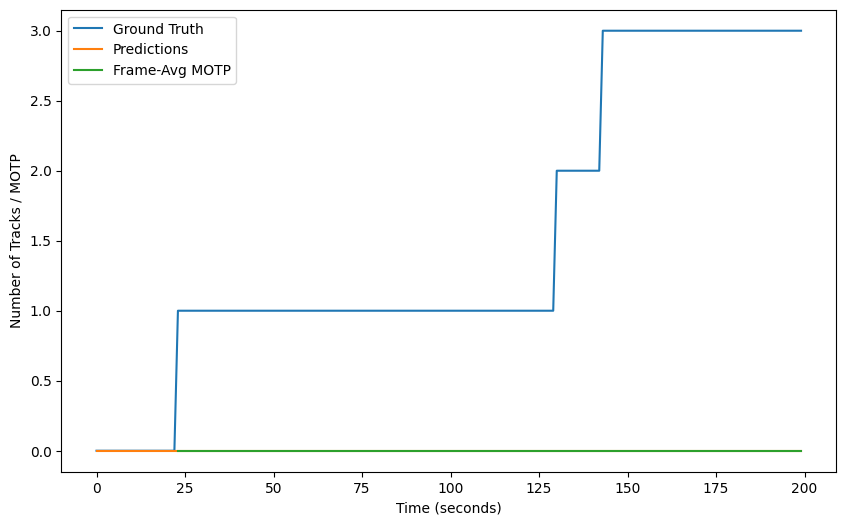

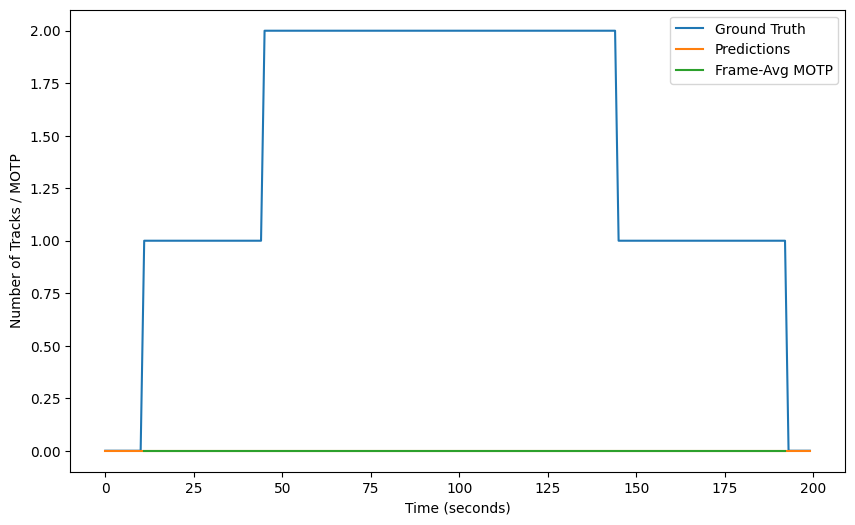

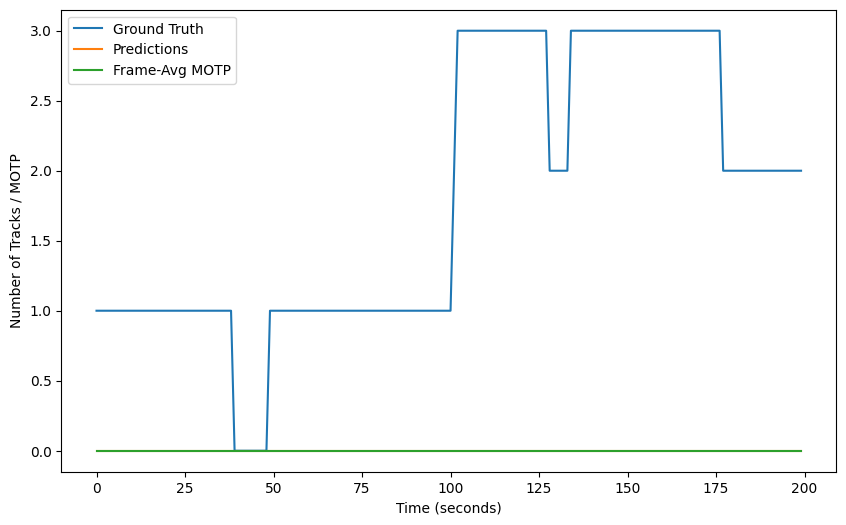

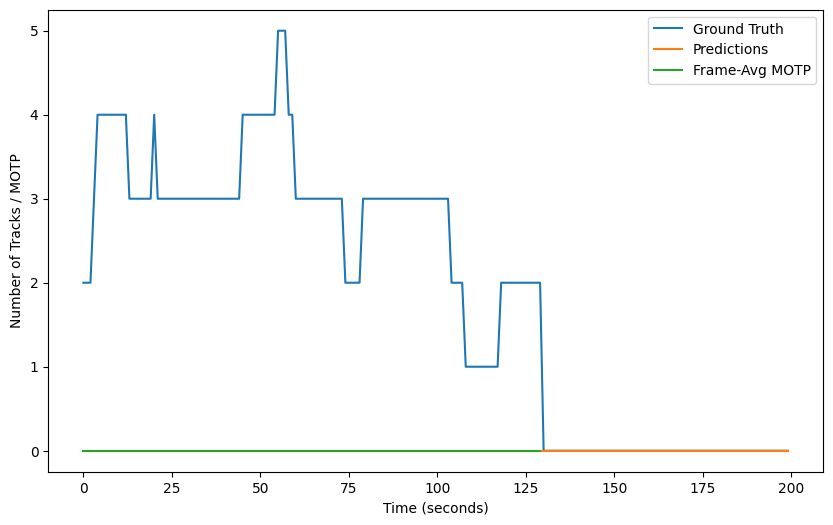

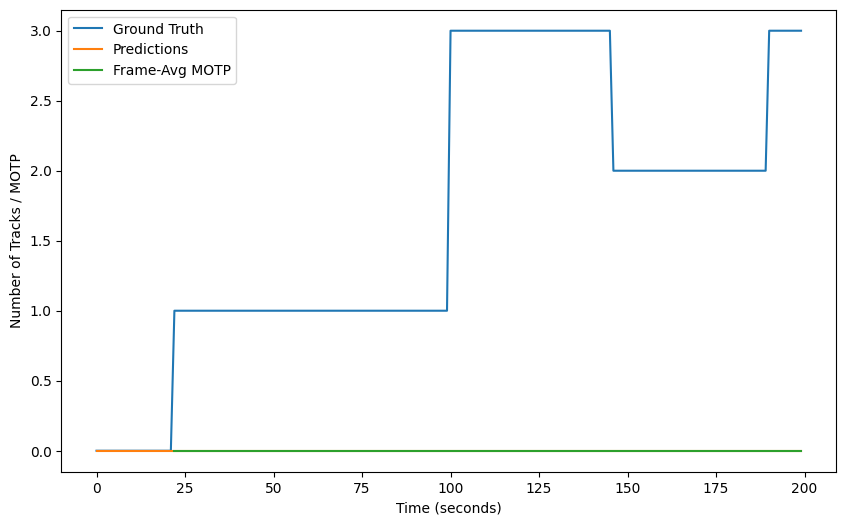

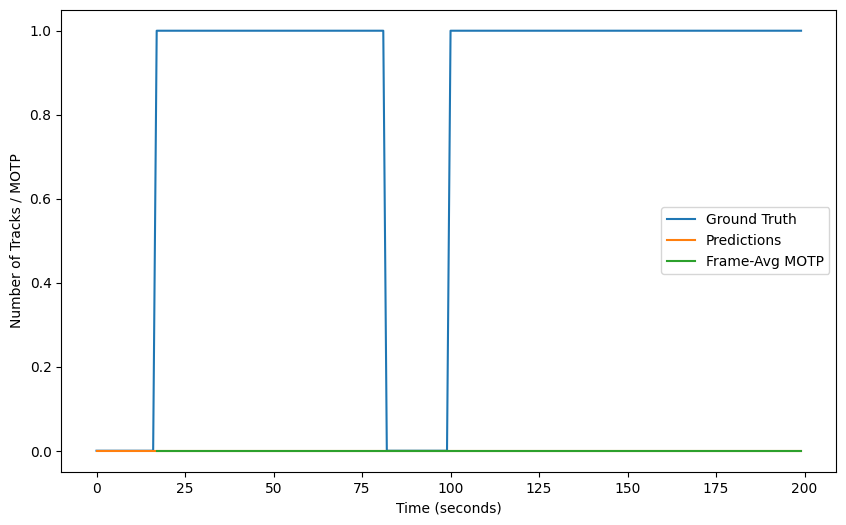

In [14]:
model_experimentation(hyperparameters)